In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import wasserstein_distance, ks_2samp

import matplotlib.pyplot as plt

def view_single_distribution(
    df,
    metric="area",
    bins=50,
    density=True,
    ax=None,
    title_prefix=""
):
    """
    View a histogram of a single metric from a DataFrame containing
    columns like: ['video', 'frame', 'area', 'eccentricity', 'solidity', 'perimeter'].

    Args:
        df (pd.DataFrame): The input DataFrame.
        metric (str): Which column to visualize, e.g. 'area', 'eccentricity', 'solidity', 'perimeter'.
        bins (int): Number of histogram bins.
        density (bool): Whether to normalize the histogram (density=True) or show counts (density=False).
        ax (matplotlib.axes.Axes, optional): Matplotlib Axes to plot on. 
            If None, a new figure/axes is created.
        title_prefix (str, optional): An optional prefix added to the plot title (e.g. "Real" or "Generated").

    Returns:
        matplotlib.axes.Axes: The axes on which the histogram was plotted.
    """
    if metric not in df.columns:
        raise ValueError(
            f"Metric '{metric}' not found in DataFrame columns. "
            f"Available columns: {df.columns.tolist()}"
        )

    # Drop any NaN or invalid values
    values = df[metric].dropna()

    # Create new figure/axes if none provided
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 6))

    # Plot histogram
    ax.hist(values, bins=bins, alpha=0.7, edgecolor="black", density=density)
    ax.set_title(f"{title_prefix} {metric.capitalize()} Distribution")
    ax.set_xlabel(metric)
    ax.set_ylabel("Density" if density else "Count")

    return ax

def compare_distributions_wasserstein(df_real, df_gen, metric):
    """Compute Wasserstein distance for the given metric."""
    real_values = df_real[metric].dropna()
    gen_values  = df_gen[metric].dropna()
    return wasserstein_distance(real_values, gen_values)

def compare_distributions_ks(df_real, df_gen, metric):
    """Compute KS statistic for the given metric."""
    real_values = df_real[metric].dropna()
    gen_values  = df_gen[metric].dropna()
    ks_stat, ks_pval = ks_2samp(real_values, gen_values)
    return ks_stat, ks_pval

def plot_overlaid_histograms(df_real, df_gen, metric, ax, bins=50):
    """Plot two overlaid histograms for the given metric."""
    real_values = df_real[metric].dropna()
    gen_values  = df_gen[metric].dropna()
    ax.hist(real_values, bins=bins, alpha=0.5, label="Real", density=True)
    ax.hist(gen_values,  bins=bins, alpha=0.5, label="Generated", density=True)
    ax.set_xlabel(metric)
    ax.set_ylabel("Density")
    ax.legend()

In [12]:
############################################################
# 1) LOAD PROLIFERATION DATAFRAMES
###########################################################
BASE = "../../results/t2v"
BASE_IDR = f"{BASE}/IDR0013-FILTERED-Test"
END = "proliferation_metrics.csv"
dfs_prolif = {
    "all": pd.read_csv(f"{BASE_IDR}/{END}"),
    "cc-high": pd.read_csv(f"{BASE_IDR}-cc-HIGH/{END}"),
    "cc-low": pd.read_csv(f"{BASE_IDR}-cc-LOW/{END}"),
    "pr-high": pd.read_csv(f"{BASE_IDR}-pr-HIGH/{END}"),
    "pr-low": pd.read_csv(f"{BASE_IDR}-pr-LOW/{END}"),
    "ms-high": pd.read_csv(f"{BASE_IDR}-ms-HIGH/{END}"),
    "ms-low": pd.read_csv(f"{BASE_IDR}-ms-LOW/{END}"),
    "prompt_pr_pr-HIGH": pd.read_csv(f"{BASE}/prompt_pr_pr-HIGH/{END}"),
    "prompt_pr_pr-LOW": pd.read_csv(f"{BASE}/prompt_pr_pr-LOW/{END}"),
    "prompt_cc_cc-HIGH": pd.read_csv(f"{BASE}/prompt_cc_cc-HIGH/{END}"),
    "prompt_cc_cc-LOW": pd.read_csv(f"{BASE}/prompt_cc_cc-LOW/{END}"),
    "prompt_ms_ms-HIGH": pd.read_csv(f"{BASE}/prompt_ms_ms-HIGH/{END}"),
    "prompt_ms_ms-LOW": pd.read_csv(f"{BASE}/prompt_ms_ms-LOW/{END}"),
    "phenotype_alive_alive": pd.read_csv(f"{BASE}/phenotype_alive_alive/{END}"),
    "phenotype_dead_dead": pd.read_csv(f"{BASE}/phenotype_dead_dead/{END}"),
    "phenotype_cc_cc-HIGH": pd.read_csv(f"{BASE}/phenotype_cc_cc-HIGH/{END}"),
    "phenotype_cc_cc-LOW": pd.read_csv(f"{BASE}/phenotype_cc_cc-LOW/{END}"),
    "phenotype_ms_ms-HIGH": pd.read_csv(f"{BASE}/phenotype_ms_ms-HIGH/{END}"),
    "phenotype_ms_ms-LOW": pd.read_csv(f"{BASE}/phenotype_ms_ms-LOW/{END}"),
    "uncond_frames81": pd.read_csv(f"{BASE}/uncond_frames81/{END}"),
    # "phenotype_pr_pr-HIGH": pd.read_csv(f"{BASE}/phenotype_pr_pr-HIGH/{END}"),
    # "phenotype_pr_pr-LOW": pd.read_csv(f"{BASE}/phenotype_pr_pr-LOW/{END}"),
}

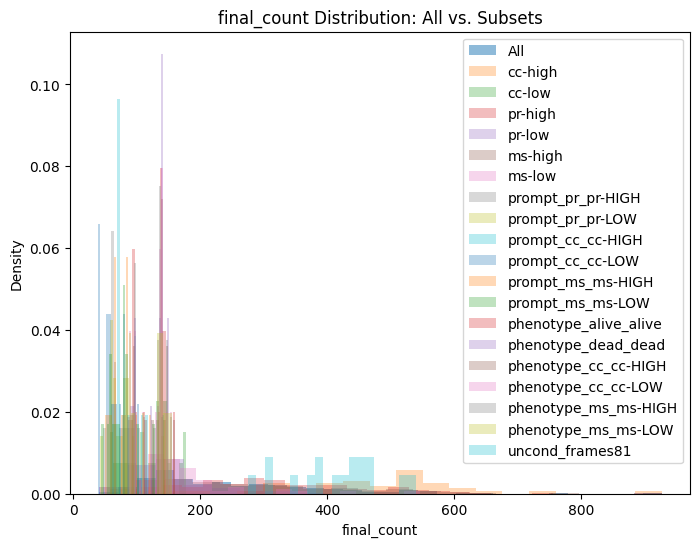

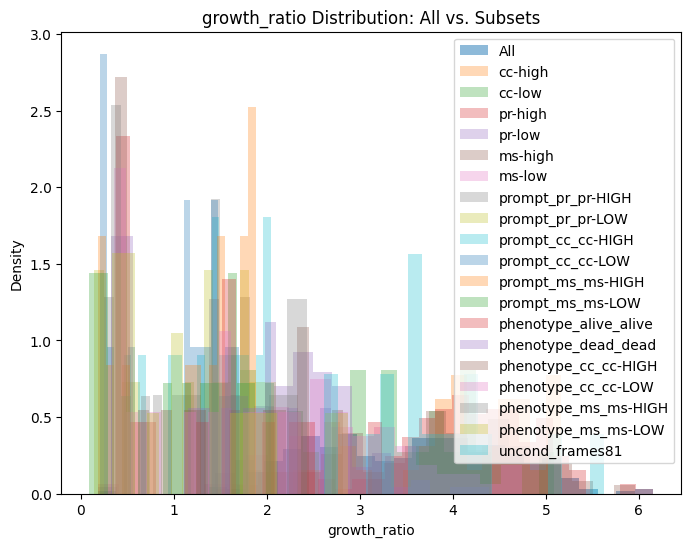

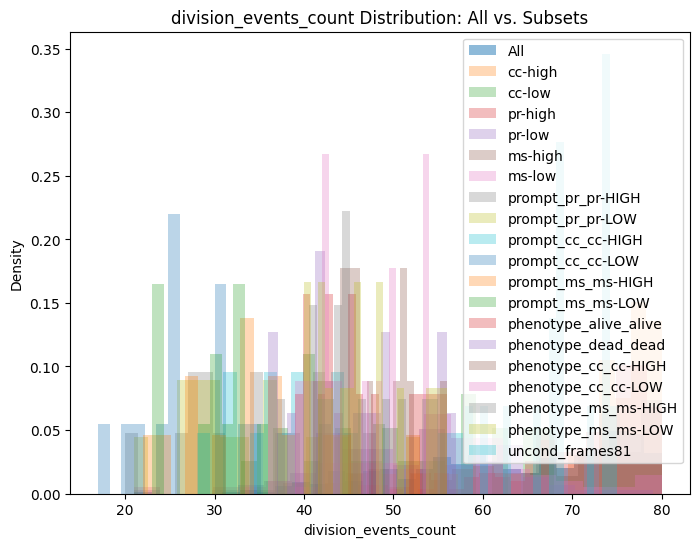

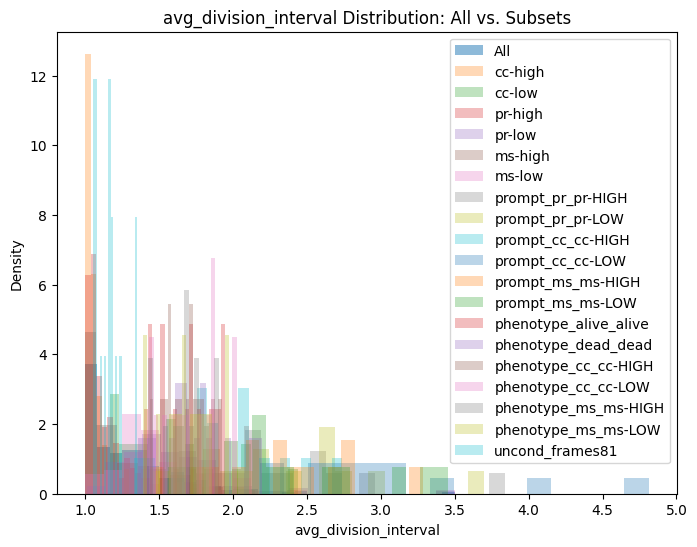

In [13]:
# List of columns in proliferation_metrics.csv that we want to compare
prolif_metrics = [
    "final_count",
    "growth_ratio",
    "division_events_count",
    "avg_division_interval"
]

############################################################
# 2) PLOT OVERLAID HISTOGRAMS FOR EACH PROLIFERATION METRIC
############################################################
import matplotlib.pyplot as plt

for metric in prolif_metrics:
    plt.figure(figsize=(8,6))
    # Plot real distribution
    real_vals = dfs_prolif["all"][metric].dropna()
    plt.hist(real_vals, bins=30, alpha=0.5, density=True, label="All")

    # Plot each checkpoint overlay
    for name, df in dfs_prolif.items():
        if name == "all":
            continue
        gen_vals = df[metric].dropna()
        plt.hist(gen_vals, bins=20, alpha=0.3, density=True, label=name)

    plt.title(f"{metric} Distribution: All vs. Subsets")
    plt.xlabel(metric)
    plt.ylabel("Density")
    plt.legend()
    plt.show()

### cc-low

In [25]:

prolif_metrics = [
    "final_count",
]
key = "cc-low"
############################################################
# 3) COMPUTE DISTRIBUTION DISTANCES (E.G. WASSERSTEIN, KS)
############################################################
from scipy.stats import wasserstein_distance, ks_2samp
results = []

for checkpoint_name, df_gen in dfs_prolif.items():
    if checkpoint_name == key:
        continue  # skip comparing reference with itself
    for metric in prolif_metrics:
        real_vals = dfs_prolif[key][metric].dropna()
        gen_vals  = df_gen[metric].dropna()
        
        if len(real_vals) == 0 or len(gen_vals) == 0:
            # If no data, skip
            continue

        # Compute Wasserstein and KS
        wdist  = wasserstein_distance(real_vals, gen_vals)
        ks_stat, ks_pval = ks_2samp(real_vals, gen_vals)

        results.append({
            "checkpoint": checkpoint_name,
            "metric": metric,
            "wasserstein_distance": wdist,
            "ks_stat": ks_stat,
            "ks_pval": ks_pval
        })

df_prolif_results = pd.DataFrame(results)
df_prolif_results

for metric in prolif_metrics:
    # Filter rows for this metric
    subdf = df_prolif_results[df_prolif_results["metric"] == metric].copy()
    
    # Sort by wasserstein_distance ascending (lowest distance = best)
    subdf = subdf.sort_values("wasserstein_distance")
    
    print(f"\n=== Ranking for '{metric}' by Wasserstein Distance ===")
    display(subdf[["checkpoint", "metric", "wasserstein_distance"]])


=== Ranking for 'final_count' by Wasserstein Distance ===


,checkpoint,metric,wasserstein_distance
17,phenotype_ms_ms-LOW,final_count,15.657576
14,phenotype_cc_cc-HIGH,final_count,16.057576
16,phenotype_ms_ms-HIGH,final_count,16.966667
15,phenotype_cc_cc-LOW,final_count,17.057576
12,phenotype_alive_alive,final_count,17.184848
13,phenotype_dead_dead,final_count,18.621212
8,prompt_cc_cc-HIGH,final_count,28.863636
6,prompt_pr_pr-HIGH,final_count,39.148485
10,prompt_ms_ms-HIGH,final_count,39.181818
7,prompt_pr_pr-LOW,final_count,39.896104


In [26]:

prolif_metrics = [
    "final_count",
]
key = "cc-high"
############################################################
# 3) COMPUTE DISTRIBUTION DISTANCES (E.G. WASSERSTEIN, KS)
############################################################
from scipy.stats import wasserstein_distance, ks_2samp
results = []

for checkpoint_name, df_gen in dfs_prolif.items():
    if checkpoint_name == key:
        continue  # skip comparing reference with itself
    for metric in prolif_metrics:
        real_vals = dfs_prolif[key][metric].dropna()
        gen_vals  = df_gen[metric].dropna()
        
        if len(real_vals) == 0 or len(gen_vals) == 0:
            # If no data, skip
            continue

        # Compute Wasserstein and KS
        wdist  = wasserstein_distance(real_vals, gen_vals)
        ks_stat, ks_pval = ks_2samp(real_vals, gen_vals)

        results.append({
            "checkpoint": checkpoint_name,
            "metric": metric,
            "wasserstein_distance": wdist,
            "ks_stat": ks_stat,
            "ks_pval": ks_pval
        })

df_prolif_results = pd.DataFrame(results)
df_prolif_results

for metric in prolif_metrics:
    # Filter rows for this metric
    subdf = df_prolif_results[df_prolif_results["metric"] == metric].copy()
    
    # Sort by wasserstein_distance ascending (lowest distance = best)
    subdf = subdf.sort_values("wasserstein_distance")
    
    print(f"\n=== Ranking for '{metric}' by Wasserstein Distance ===")
    display(subdf[["checkpoint", "metric", "wasserstein_distance"]])


=== Ranking for 'final_count' by Wasserstein Distance ===


,checkpoint,metric,wasserstein_distance
18,uncond_frames81,final_count,80.473684
2,pr-high,final_count,151.708345
4,ms-high,final_count,192.732794
0,all,final_count,223.599005
5,ms-low,final_count,301.378947
3,pr-low,final_count,309.301170
13,phenotype_dead_dead,final_count,342.378947
12,phenotype_alive_alive,final_count,342.403509
14,phenotype_cc_cc-HIGH,final_count,343.178947
16,phenotype_ms_ms-HIGH,final_count,343.512281


In [27]:

prolif_metrics = [
    "growth_ratio",
]
key = "pr-high"
############################################################
# 3) COMPUTE DISTRIBUTION DISTANCES (E.G. WASSERSTEIN, KS)
############################################################
from scipy.stats import wasserstein_distance, ks_2samp
results = []

for checkpoint_name, df_gen in dfs_prolif.items():
    if checkpoint_name == key:
        continue  # skip comparing reference with itself
    for metric in prolif_metrics:
        real_vals = dfs_prolif[key][metric].dropna()
        gen_vals  = df_gen[metric].dropna()
        
        if len(real_vals) == 0 or len(gen_vals) == 0:
            # If no data, skip
            continue

        # Compute Wasserstein and KS
        wdist  = wasserstein_distance(real_vals, gen_vals)
        ks_stat, ks_pval = ks_2samp(real_vals, gen_vals)

        results.append({
            "checkpoint": checkpoint_name,
            "metric": metric,
            "wasserstein_distance": wdist,
            "ks_stat": ks_stat,
            "ks_pval": ks_pval
        })

df_prolif_results = pd.DataFrame(results)
df_prolif_results

for metric in prolif_metrics:
    # Filter rows for this metric
    subdf = df_prolif_results[df_prolif_results["metric"] == metric].copy()
    
    # Sort by wasserstein_distance ascending (lowest distance = best)
    subdf = subdf.sort_values("wasserstein_distance")
    
    print(f"\n=== Ranking for '{metric}' by Wasserstein Distance ===")
    display(subdf[["checkpoint", "metric", "wasserstein_distance"]])


=== Ranking for 'growth_ratio' by Wasserstein Distance ===


,checkpoint,metric,wasserstein_distance
1,cc-high,growth_ratio,0.277636
4,ms-high,growth_ratio,0.448666
18,uncond_frames81,growth_ratio,0.466805
0,all,growth_ratio,0.731183
2,cc-low,growth_ratio,0.973900
5,ms-low,growth_ratio,1.401318
3,pr-low,growth_ratio,1.777567
8,prompt_cc_cc-HIGH,growth_ratio,2.816451
6,prompt_pr_pr-HIGH,growth_ratio,2.843652
12,phenotype_alive_alive,growth_ratio,2.925069


In [28]:

prolif_metrics = [
    "growth_ratio",
]
key = "pr-low"
############################################################
# 3) COMPUTE DISTRIBUTION DISTANCES (E.G. WASSERSTEIN, KS)
############################################################
from scipy.stats import wasserstein_distance, ks_2samp
results = []

for checkpoint_name, df_gen in dfs_prolif.items():
    if checkpoint_name == key:
        continue  # skip comparing reference with itself
    for metric in prolif_metrics:
        real_vals = dfs_prolif[key][metric].dropna()
        gen_vals  = df_gen[metric].dropna()
        
        if len(real_vals) == 0 or len(gen_vals) == 0:
            # If no data, skip
            continue

        # Compute Wasserstein and KS
        wdist  = wasserstein_distance(real_vals, gen_vals)
        ks_stat, ks_pval = ks_2samp(real_vals, gen_vals)

        results.append({
            "checkpoint": checkpoint_name,
            "metric": metric,
            "wasserstein_distance": wdist,
            "ks_stat": ks_stat,
            "ks_pval": ks_pval
        })

df_prolif_results = pd.DataFrame(results)
df_prolif_results

for metric in prolif_metrics:
    # Filter rows for this metric
    subdf = df_prolif_results[df_prolif_results["metric"] == metric].copy()
    
    # Sort by wasserstein_distance ascending (lowest distance = best)
    subdf = subdf.sort_values("wasserstein_distance")
    
    print(f"\n=== Ranking for '{metric}' by Wasserstein Distance ===")
    display(subdf[["checkpoint", "metric", "wasserstein_distance"]])


=== Ranking for 'growth_ratio' by Wasserstein Distance ===


,checkpoint,metric,wasserstein_distance
5,ms-low,growth_ratio,0.389041
2,cc-low,growth_ratio,0.809661
8,prompt_cc_cc-HIGH,growth_ratio,1.044032
0,all,growth_ratio,1.046383
6,prompt_pr_pr-HIGH,growth_ratio,1.067395
16,phenotype_ms_ms-HIGH,growth_ratio,1.151151
12,phenotype_alive_alive,growth_ratio,1.151779
15,phenotype_cc_cc-LOW,growth_ratio,1.162348
14,phenotype_cc_cc-HIGH,growth_ratio,1.165911
13,phenotype_dead_dead,growth_ratio,1.178254
